In [60]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [61]:
# --- Configuration ---
DATASET_PATH = Path("data_split")

dynamic_feature_cols = ['flops', 'non_zero_params', 'params_reduction_pct', 'flops_reduction_pct']
target_col = 'overall_accuracy'
INTERMEDIATE_THRESHOLDS = np.round(np.arange(0.1, 10.0, 0.1), 1) # 99 points
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [62]:
# --- Helper Function to Prepare Sequences from a DataFrame ---
def prepare_sequences_from_df(df, dynamic_cols, target_col_name, intermediate_thresholds_list):
    """
    Prepares X and y sequences from a given DataFrame.
    Also returns a dictionary of actual acc@10 values and model_ids.
    """
    X_list_local = []
    y_list_local = []
    actual_acc10_dict_local = {}
    model_ids_processed_local = []
    skipped_count_local = 0

    for model_id, group in df.groupby('model_id'):
        group = group.sort_values(by='threshold').reset_index(drop=True)

        acc_at_0_series = group[group['threshold'] == 0.0][target_col_name]
        acc_at_10_series = group[group['threshold'] == 10.0][target_col_name]

        if acc_at_0_series.empty or acc_at_10_series.empty:
            skipped_count_local += 1
            continue
        
        acc_0_val = acc_at_0_series.iloc[0]
        actual_acc10_dict_local[model_id] = acc_at_10_series.iloc[0]

        intermediate_data = group[group['threshold'].isin(intermediate_thresholds_list)].copy()
        if len(intermediate_data) != len(intermediate_thresholds_list):
            skipped_count_local += 1
            continue
        intermediate_data = intermediate_data.sort_values(by='threshold').reset_index(drop=True)

        current_dynamic_features = intermediate_data[dynamic_cols].values
        acc_0_feature_repeated = np.tile(acc_0_val, (len(intermediate_thresholds_list), 1))

        lagged_accuracies = np.zeros((len(intermediate_thresholds_list), 1))
        lagged_accuracies[0] = acc_0_val
        if len(intermediate_thresholds_list) > 1:
            lagged_accuracies[1:] = intermediate_data[target_col_name].values[:-1].reshape(-1,1)

        model_X_sample = np.concatenate([
            current_dynamic_features,
            acc_0_feature_repeated,
            lagged_accuracies
        ], axis=1)
        X_list_local.append(model_X_sample)

        model_y_sample = intermediate_data[target_col_name].values.reshape(-1, 1)
        y_list_local.append(model_y_sample)
        model_ids_processed_local.append(model_id)
        
    if not X_list_local:
        raise ValueError(f"No valid sequences prepared from the provided DataFrame. Skipped {skipped_count_local} models.")
    
    print(f"Prepared {len(X_list_local)} sequences, skipped {skipped_count_local} models.")
    return np.array(X_list_local), np.array(y_list_local), actual_acc10_dict_local, model_ids_processed_local

In [63]:
# --- 1. Load Pre-split Datasets ---
print("Loading pre-split datasets...")
try:
    train_df_raw = pd.read_csv(DATASET_PATH / "train_dataset.csv")
    validation_df_raw = pd.read_csv(DATASET_PATH / "validation_dataset.csv")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Make sure '{e.filename}' exists.")
    print(f"Please run the `prepare_datasets.py` script first to generate these files in '{DATASET_PATH}'.")
    exit()

# Round the threshold column to fix precision issues
print("Rounding threshold column to 1 decimal place...")
train_df = train_df_raw.copy()
train_df['threshold'] = train_df['threshold'].round(1)

validation_df = validation_df_raw.copy()
validation_df['threshold'] = validation_df['threshold'].round(1)

print(f"Training data shape (after rounding): {train_df.shape}")
print(f"Validation data shape (after rounding): {validation_df.shape}")

Loading pre-split datasets...
Rounding threshold column to 1 decimal place...
Training data shape (after rounding): (1313, 18)
Validation data shape (after rounding): (202, 18)


In [64]:
# --- 2. Prepare Sequences for Training and Validation Data ---
print("\nPreparing training sequences...")
X_train_all_samples, y_train_all_samples, _, train_model_ids = \
    prepare_sequences_from_df(train_df, dynamic_feature_cols, target_col, INTERMEDIATE_THRESHOLDS)

print("\nPreparing validation sequences...")
X_val_all_samples, y_val_all_samples, actual_acc10_for_val, val_model_ids = \
    prepare_sequences_from_df(validation_df, dynamic_feature_cols, target_col, INTERMEDIATE_THRESHOLDS)

print(f"\nTraining data for LSTM: X_train_all_samples shape: {X_train_all_samples.shape}, y_train_all_samples shape: {y_train_all_samples.shape}")
print(f"Validation data for LSTM: X_val_all_samples shape: {X_val_all_samples.shape}, y_val_all_samples shape: {y_val_all_samples.shape}")


Preparing training sequences...
Prepared 13 sequences, skipped 0 models.

Preparing validation sequences...
Prepared 2 sequences, skipped 0 models.

Training data for LSTM: X_train_all_samples shape: (13, 99, 6), y_train_all_samples shape: (13, 99, 1)
Validation data for LSTM: X_val_all_samples shape: (2, 99, 6), y_val_all_samples shape: (2, 99, 1)


In [65]:
# --- 3. Scaling (Fit on Training Data ONLY, then Transform Both) ---
num_dynamic_features = len(dynamic_feature_cols)
num_acc_like_features_in_X = 2 # acc_0_feat, lagged_acc_feat

# -- Scaler for dynamic features --
x_dynamic_scaler = MinMaxScaler()
# Fit on training dynamic features
X_train_dynamic_part_reshaped = X_train_all_samples[:, :, :num_dynamic_features].reshape(-1, num_dynamic_features)
x_dynamic_scaler.fit(X_train_dynamic_part_reshaped)
# Transform training dynamic features
X_train_dynamic_part_scaled_reshaped = x_dynamic_scaler.transform(X_train_dynamic_part_reshaped)
X_train_dynamic_part_scaled = X_train_dynamic_part_scaled_reshaped.reshape(X_train_all_samples.shape[0], X_train_all_samples.shape[1], num_dynamic_features)
# Transform validation dynamic features
X_val_dynamic_part_reshaped = X_val_all_samples[:, :, :num_dynamic_features].reshape(-1, num_dynamic_features)
X_val_dynamic_part_scaled_reshaped = x_dynamic_scaler.transform(X_val_dynamic_part_reshaped)
X_val_dynamic_part_scaled = X_val_dynamic_part_scaled_reshaped.reshape(X_val_all_samples.shape[0], X_val_all_samples.shape[1], num_dynamic_features)

# -- Scaler for accuracy-like features --
y_acc_scaler = MinMaxScaler()
# Fit on training accuracy-like features (from X and y)
train_acc_feat_col_idx_start = num_dynamic_features
train_x_acc_features_part = X_train_all_samples[:, :, train_acc_feat_col_idx_start : train_acc_feat_col_idx_start + num_acc_like_features_in_X]
train_all_x_acc_features_flat = train_x_acc_features_part.flatten()
train_all_y_values_flat = y_train_all_samples.flatten()
train_all_acc_values_for_fitting = np.concatenate([train_all_x_acc_features_flat, train_all_y_values_flat])
y_acc_scaler.fit(train_all_acc_values_for_fitting.reshape(-1, 1))

# Transform training accuracy-like features in X
X_train_acc_part_scaled_list = []
for i in range(num_acc_like_features_in_X):
    current_acc_feature_col_idx = num_dynamic_features + i
    acc_feature_column_data = X_train_all_samples[:, :, current_acc_feature_col_idx]
    scaled_column_reshaped = y_acc_scaler.transform(acc_feature_column_data.reshape(-1, 1))
    X_train_acc_part_scaled_list.append(scaled_column_reshaped.reshape(X_train_all_samples.shape[0], X_train_all_samples.shape[1], 1))
X_train_acc_part_scaled = np.concatenate(X_train_acc_part_scaled_list, axis=2)
# Transform training y
y_train_scaled_reshaped = y_acc_scaler.transform(y_train_all_samples.reshape(-1, 1))
y_train_scaled = y_train_scaled_reshaped.reshape(y_train_all_samples.shape)

# Transform validation accuracy-like features in X
X_val_acc_part_scaled_list = []
for i in range(num_acc_like_features_in_X):
    current_acc_feature_col_idx = num_dynamic_features + i
    acc_feature_column_data = X_val_all_samples[:, :, current_acc_feature_col_idx]
    scaled_column_reshaped = y_acc_scaler.transform(acc_feature_column_data.reshape(-1, 1))
    X_val_acc_part_scaled_list.append(scaled_column_reshaped.reshape(X_val_all_samples.shape[0], X_val_all_samples.shape[1], 1))
X_val_acc_part_scaled = np.concatenate(X_val_acc_part_scaled_list, axis=2)
# Transform validation y
y_val_scaled_reshaped = y_acc_scaler.transform(y_val_all_samples.reshape(-1, 1))
y_val_scaled = y_val_scaled_reshaped.reshape(y_val_all_samples.shape)

# -- Combine scaled parts for X_train and X_val --
X_train_scaled = np.concatenate([X_train_dynamic_part_scaled, X_train_acc_part_scaled], axis=2)
X_val_scaled = np.concatenate([X_val_dynamic_part_scaled, X_val_acc_part_scaled], axis=2)

print(f"\nScaled Training X shape: {X_train_scaled.shape}, Scaled Training y shape: {y_train_scaled.shape}")
print(f"Scaled Validation X shape: {X_val_scaled.shape}, Scaled Validation y shape: {y_val_scaled.shape}")


Scaled Training X shape: (13, 99, 6), Scaled Training y shape: (13, 99, 1)
Scaled Validation X shape: (2, 99, 6), Scaled Validation y shape: (2, 99, 1)


In [66]:
# --- 4. Build LSTM Model ---
sequence_length = X_train_scaled.shape[1]
n_features_per_step = X_train_scaled.shape[2]

print(f"\nSequence length: {sequence_length}, Number of features per step: {n_features_per_step}")

model = Sequential([
    Input(shape=(sequence_length, n_features_per_step)),
    LSTM(units=12, return_sequences=True),
    TimeDistributed(Dense(units=1)),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
model.summary()


Sequence length: 99, Number of features per step: 6


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 99, 12)         │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 99, 1)          │            13 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 925 (3.61 KB)

 Trainable params: 925 (3.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0723 - mae: 0.2300 - val_loss: 0.0571 - val_mae: 0.2269
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0617 - mae: 0.2152 - val_loss: 0.0479 - val_mae: 0.2073
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0587 - mae: 0.2153 - val_loss: 0.0407 - val_mae: 0.1881
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0540 - mae: 0.2077 - val_loss: 0.0341 - val_mae: 0.1694
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0481 - mae: 0.1950 - val_loss: 0.0285 - val_mae: 0.1511
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0428 - mae: 0.1816 - val_loss: 0.0240 - val_mae: 0.1337
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0386 - mae: 0.1696 - val_loss: 0.0204 - val_mae: 0.1173
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0354 - mae: 0.1589 - val_loss: 0.0177 - val_mae: 0.1023
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.03

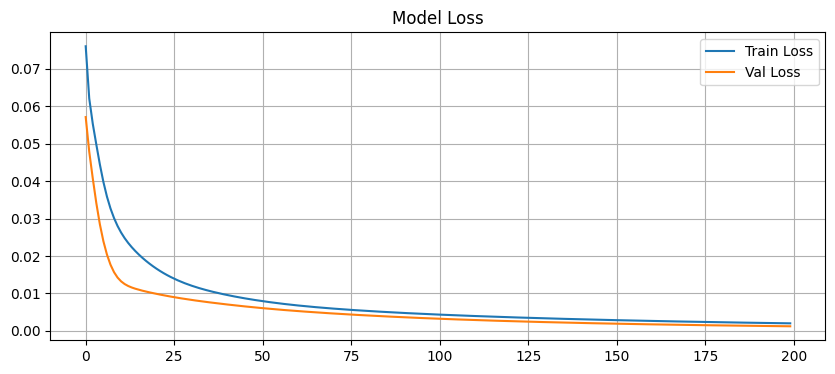

In [67]:
# --- 5. Train Model ---
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=max(1, X_train_scaled.shape[0] // 8 if X_train_scaled.shape[0] > 0 else 1),
    validation_data=(X_val_scaled, y_val_scaled), # Use scaled validation data here
    callbacks=[early_stopping],
    verbose=1
)
plt.figure(figsize=(10,4)); plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss'); plt.title('Model Loss'); plt.legend(); plt.grid(True); plt.show()


# --- Auto-Regressive Prediction Function (from previous script, no changes needed) ---
def predict_auto_regressively_no_acc10(model_to_use,
                                       unscaled_dynamic_features_sample,
                                       unscaled_acc_0,
                                       x_dynamic_scaler_model, y_acc_scaler_model,
                                       seq_len, num_dyn_feat):
    scaled_dynamic_features = x_dynamic_scaler_model.transform(unscaled_dynamic_features_sample)
    scaled_acc_0_val = y_acc_scaler_model.transform(np.array([[unscaled_acc_0]]))[0,0]
    scaled_acc_0_feat_repeated = np.tile(scaled_acc_0_val, (seq_len, 1))
    current_input_X = np.zeros((1, seq_len, num_dyn_feat + 2))
    current_input_X[0, :, :num_dyn_feat] = scaled_dynamic_features
    current_input_X[0, :, num_dyn_feat] = scaled_acc_0_feat_repeated[:,0]
    last_predicted_acc_scaled = scaled_acc_0_val
    generated_sequence_scaled = np.zeros(seq_len)
    for t in range(seq_len):
        current_input_X[0, t, num_dyn_feat + 1] = last_predicted_acc_scaled
        prediction_all_steps_scaled = model_to_use.predict(current_input_X, verbose=0)
        current_step_pred_scaled = prediction_all_steps_scaled[0, t, 0]
        generated_sequence_scaled[t] = current_step_pred_scaled
        last_predicted_acc_scaled = current_step_pred_scaled
    return y_acc_scaler_model.inverse_transform(generated_sequence_scaled.reshape(-1,1)).flatten()

In [68]:
# --- 6. Evaluate with Auto-Regressive Prediction on VALIDATION Set ---
print("\nPerforming auto-regressive benchmark on VALIDATION set...")
all_auto_regressive_preds_val = []
all_y_val_original = [] # For storing unscaled y_val

# X_val_all_samples is the unscaled version of X for validation
for i in range(X_val_all_samples.shape[0]): # Iterate through validation samples
    unscaled_dyn_features = X_val_all_samples[i, :, :num_dynamic_features]
    unscaled_acc0_for_sample = X_val_all_samples[i, 0, num_dynamic_features] # acc_0 is at this index

    predicted_curve = predict_auto_regressively_no_acc10(
        model,
        unscaled_dyn_features,
        unscaled_acc0_for_sample,
        x_dynamic_scaler, y_acc_scaler, # Use the fitted scalers
        sequence_length, num_dynamic_features
    )
    all_auto_regressive_preds_val.append(predicted_curve)
    
    # y_val_all_samples is the unscaled version of y for validation
    y_val_original_sample = y_val_all_samples[i].flatten() # Already unscaled
    all_y_val_original.append(y_val_original_sample)

all_auto_regressive_preds_val = np.array(all_auto_regressive_preds_val)
all_y_val_original = np.array(all_y_val_original) # Convert list of arrays to 2D array

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_ar_val = mean_absolute_error(all_y_val_original.flatten(), all_auto_regressive_preds_val.flatten())
mse_ar_val = mean_squared_error(all_y_val_original.flatten(), all_auto_regressive_preds_val.flatten())
print(f"\nAuto-Regressive VALIDATION MAE (original scale): {mae_ar_val:.4f}")
print(f"Auto-Regressive VALIDATION MSE (original scale): {mse_ar_val:.4f}")


Performing auto-regressive benchmark on VALIDATION set...

Auto-Regressive VALIDATION MAE (original scale): 0.0846
Auto-Regressive VALIDATION MSE (original scale): 0.0090



Visualizing predictions for 2 validation samples...


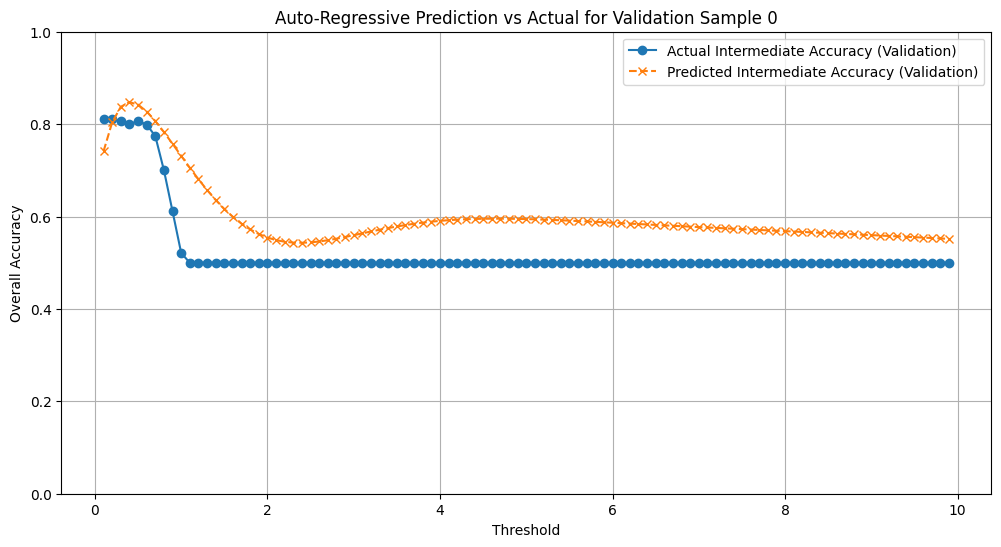

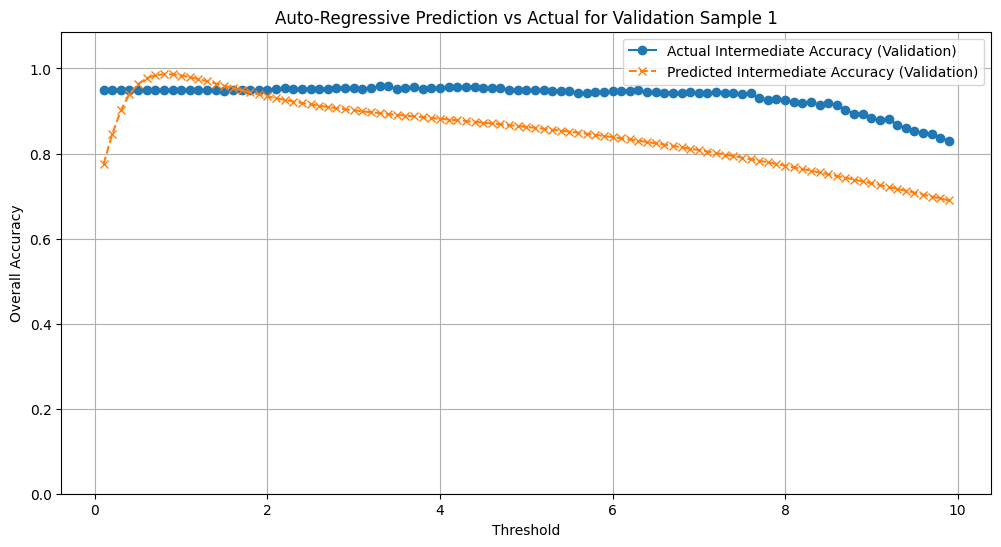

In [69]:
# --- 7. Visualize Predictions on VALIDATION Set ---
num_samples_to_plot = min(3, X_val_all_samples.shape[0])
print(f"\nVisualizing predictions for {num_samples_to_plot} validation samples...")
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))
    plt.plot(INTERMEDIATE_THRESHOLDS, all_y_val_original[i], label='Actual Intermediate Accuracy (Validation)', marker='o', linestyle='-')
    plt.plot(INTERMEDIATE_THRESHOLDS, all_auto_regressive_preds_val[i], label='Predicted Intermediate Accuracy (Validation)', marker='x', linestyle='--')

    plt.title(f"Auto-Regressive Prediction vs Actual for Validation Sample {i}")
    plt.xlabel("Threshold")
    plt.ylabel("Overall Accuracy")
    plt.legend()
    plt.grid(True)
    min_val = min(0, np.min(all_y_val_original[i]) - 0.1, np.min(all_auto_regressive_preds_val[i]) - 0.1 if len(all_auto_regressive_preds_val[i]) > 0 else 0)
    max_val = max(1, np.max(all_y_val_original[i]) + 0.1, np.max(all_auto_regressive_preds_val[i]) + 0.1 if len(all_auto_regressive_preds_val[i]) > 0 else 1)
    plt.ylim(min_val, max_val)
    plt.show()